Introduction to Data Science <br> Winter 2018

# Homework 8
Due Saturday, 3/3/2018 , 3:00am

Please complete this notebook by filling in the cells provided. Once you are finished, "Save and Checkpoint" the notebook, download the ipynb and html versions to your computer, and submit the html version. 

**Total points: ** 130

A summary of the methods to Table is [here](http://data8.org/datascience/tables.html) <br>
A tutorial for the datascience module is [here](http://data8.org/datascience/tutorial.html) <br>
A cheatsheet for the datascience module is [here](https://github.com/wstuetzle/STAT180/blob/master/Computing/data8_sp17_midterm_ref_sheet.pdf)

In [10]:
from datascience import *
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Part 1

In the first part of this homework we will work with Francis Galton's data on paternal and child heights. We will use code from the notebook "looking-at-pairs-of-features-part2-1-23-2018.ipynb". You should review this notebook, especially the section on "Looking at a pair of numerical features".

We are interested in the question whether there is evidence for "assortative mating" - tall men are married to tall women, and short men are married to short women.

**Question 1** (5 points): Using code from the "looking at pairs...." notebook, produce the table "galton_parents". Show the first five rows.

In [4]:
galton_parents = Table.read_table('http://inferentialthinking.com/notebooks/galton.csv')
galton_parents = galton_parents.relabeled(1, "fat_hei").relabeled(2, "mom_hei").relabeled(3, "mid_hei") \
         .relabeled(7, "chi_hei")

galton_parents.show(5)

family,fat_hei,mom_hei,mid_hei,children,childNum,gender,chi_hei
1,78.5,67,75.43,4,1,male,73.2
1,78.5,67,75.43,4,2,female,69.2
1,78.5,67,75.43,4,3,female,69
1,78.5,67,75.43,4,4,female,69
2,75.5,66.5,73.66,4,1,male,73.5


**Question 2:** (5 points) Draw a scatterplot of mom_hei (on the vertical axis) versus fat_hei.

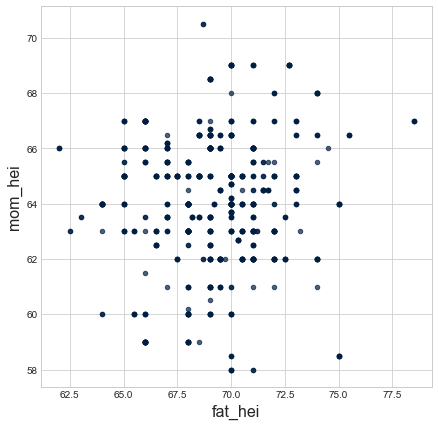

In [5]:
galton_parents.scatter("fat_hei", "mom_hei", width = 7, height = 7)

To see whether there is an association we try to predict mom_hei from fat_hei. If there is no association then randomly changing the mother-father pairings won't make the prediction any more difficult.

The logic is the same as in HW07, when we were interested in the association between birth weight and gestational days. In HW07 we used the quadrant correlation as a measure of association. Here we will use the mean squared error of a prediction rule.

We will use the conditional mean curve for prediction.

**Question 3:** (20 points) Use the function "conditional_mean_curve" from the "looking-at-pairs...." notebook to estimate the conditional mean of mom_hei for every value of fat_hei with window_width = 7. Draw the conditional mean curve.

**Note**: There was a mistake in the original version of the code for the function conditional_mean_curve. I have fixed this mistake. Please make sure you use the current version of the notebook on Canvas.

In [6]:
def conditional_mean(table, y, x, x_query, window_width, draw_histogram = False,
                     histogram_bins = None):
    '''
    From data in table estimate the conditional mean of numerical feature y, given
    numerical feature x = x_query, by averaging the values of y for the observations 
    (rows) with values of x in a window centered at x_query. 
    If draw_histogram = True the function draws a histogram of the conditional distribution. 
    ''' 
    table_sub = table.where(x, are.between(x_query - 0.5 * window_width,
                                           x_query + 0.5 * window_width))
    if draw_histogram:
        table_sub.hist(y, unit = None, bins = histogram_bins)
    return np.mean(table_sub.column(y))

In [7]:
def conditional_mean_curve(table, y, x, window_width, grid = None, plot = False):
    '''
    Plot the conditional mean of y, given x on a grid. Default grid has
    100 grid points, evenly spaced and spanning the range of the data
    '''
    if type(grid) != np.ndarray:
        ngrid = 100
        x_values = table.column(x)
        grid = np.linspace(min(x_values), max(x_values), ngrid)
    else:
        ngrid = len(grid)
    cond_mean = np.zeros(ngrid)
    for i in np.arange(ngrid):
        cond_mean[i] = conditional_mean(table, y, x, grid[i], window_width)
    tab = Table().with_columns(x, grid, ("cond_mean_of_" + y), cond_mean)
    if plot:
        tab.plot(x)
    return cond_mean
   

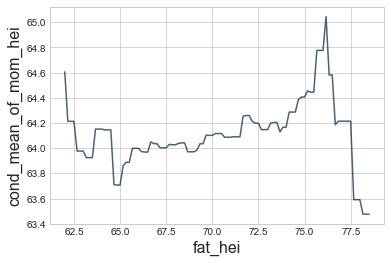

In [8]:
cond_mean = conditional_mean_curve(galton_parents, "mom_hei","fat_hei", 7, plot = True)

**Question 4:** (10 points) Calculate and output mse_original, the mean squared prediction error of the conditional mean predictor.

In [16]:
def mse(observed, predicted):
    return ((observed - predicted)**2).mean()

observed = galton_parents.column("mom_hei")

predicted = conditional_mean_curve(table =galton_parents, y = "mom_hei", x = "fat_hei", window_width = 7, grid = galton_parents.column("fat_hei"))

mse_observed = mse(observed, predicted)

mse_perm_tbl = Table().with_column("MSE", mse_observed)
mse_perm_tbl.show()

MSE
5.29855


**Question 5:** (20 points) Calculate the mse of the conditional mean for 100 random pairings of mon_hei with fat_hei. Draw a histogram of the permutation distribution of mse.

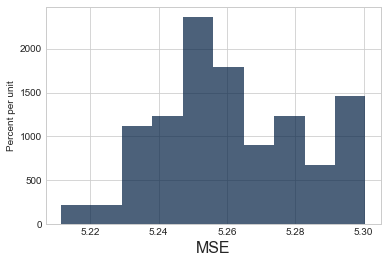

In [19]:
n_perms = 99
mses = np.zeros(n_perms + 1)
mses[0] = mse_observed

for i in np.arange(start = 1, stop = n_perms + 1):
    
    
    predicted = predicted = conditional_mean_curve(table =galton_parents, y = "mom_hei", x = "fat_hei", window_width = 7, 
                                                   grid = galton_parents.sample(with_replacement=False).column("fat_hei"))
    mses[i] = mse(observed, predicted)

mses_tbl = Table().with_column("MSE", mses)
mses_tbl.hist()

    

**Question 6:** (10 points) Calculate and output the p-value of the permutation test for the null hypotheses that there is no association between fat_hei and mom_hei.

In [22]:
p_val = (mses_tbl.column("MSE") <= mse_observed).sum() / (n_perms + 1)

p_val

0.97999999999999998

**Question 7:** (10 points) Is there evidence for assortative mating based on height? Justify your answer.

In [15]:
...

Ellipsis

## Part 2

In the second part of this homework we will carry out an alternative analysis of the cloud seeding data. You should review the notebook on "Establishing causality" where the cloud seeding data were discussed. Using a permutation test, we found strong strong evidence that cloud seeding does increase the median rainfall

**Question 8:** (5 points) Read the cloud seeding data into a table "csd" and print the first 5 rows

In [20]:
csd = Table.read_table("cloud-seeding-data (1).csv")
csd.show(5)

rainfall,treatment
4.9,unseeded
4.9,unseeded
2745.6,seeded
1697.8,seeded
1656,seeded


**Question 9:** (5 points) Calculate the difference diff_original between the median rainfall for seeded clouds and the median rainfall for unseeded clouds

In [24]:
diff_original = np.median(csd.where("treatment", are.equal_to("seeded")).column("rainfall")) \
- np.median(csd.where("treatment", are.equal_to("unseeded")).column("rainfall"))

diff_original

177.39999999999998

**Question 10:** (20 points) Calculate the difference between medians for 400 bootstrap replications. Draw a histogram of the differences.

**Note:** For each bootstrap replication you have to draw a sample of size 26 with replacement from the 26 seeded clouds and a sample of size 26 with replacement from the 26 unseeded clouds.

In [34]:
def statistics(table):
    return(np.median(table.column("rainfall")))

num_boot = 400
sample1 = csd.where("treatment", are.equal_to("seeded")).select("rainfall")
sample2 = csd.where("treatment", are.equal_to("unseeded")).select("rainfall")
seeded_sample = sample1.sample(26, with_replacement = True)
unseeded_sample = sample2.sample(26, with_replacement= True)

def bootstrap(sample, statistics, num_boot):
    resample_values = np.zeros(num_boot)
    for i in np.arange(num_boot):
        resample = sample.sample(sample.num_rows, with_replacement= True)
        resample_values[i] = statistics(resample)
    return resample_values

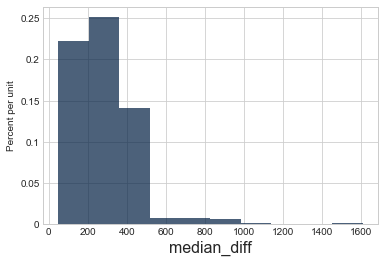

In [53]:
seeded_median = bootstrap(seeded_sample, statistics, num_boot)
unseeded_median = bootstrap(unseeded_sample, statistics, num_boot)

diff = seeded_median - unseeded_median
median_diff = Table().with_column("median_diff", diff)

median_diff.hist()

**Question 11:** (10 points) Calculate a bootstrap percentile confidence interval for confidence leven 0.95.
(The confidence interval should be an array of length 2.)

In [54]:
percentile_confidence_interval = [np.percentile(diff, 2.5), np.percentile(diff, 97.5)]
percentile_confidence_interval


[102.89874999999999, 675.72749999999985]

**Question 12:** (10 points) Does this analysis support or contradict our previous conclusion that cloud seeding increases the amount of rainfall? Explain your answer.

This analysis supports our previous conclusion that cloud seeding increases the amount of rainfall.
The original difference in median of seeded and unseeded is contained in the percentile interval with 95%. It basically tell us that the original difference lies with in the percentile confident interval which is 95%.

In [ ]:
0 is not in coinfidence interval! so it means something

duality between conf int and p_value
significant leve l20